# SVM之SMO(序列最小优化算法)实现
- 支持向量机是一种分类器，之所以叫“机”是因为它会产生一个二值决策结果，是一种决策机
- 支持向量机的泛化误差较低，即，有良好的学习能力，且学到的模型具有很好的推广性，因此被认为是监督学习中最好的定式算法
- 支持向量机通过求解一个二次优化问题来最大化分类间隔
    - 在过去，训练SVM常采用非常复杂且低效的二次规划求解方法
    - Platt引入SMO算法，通过每次只优化两个alpha值来加快SVM训练速度

## 简化版SMO实现
- 简化部分在于省去了选择alphai的外循环过程，省去了更新Ei的过程
- 写这个算法的目的在于深入理解SMO算法过程

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"

#设置出图显示中文
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 1. 辅助函数
- 数据加载函数
- 根据alphai的i随机选择j的函数
- 根据L H边界值剪切alpha的函数

In [2]:
def loadDataSet(filename):
    #filename是待读取文件的文件名或路径+文件名
    dataMat=[];labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        lineArr=line.strip().split("\t")
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def randPickj(i,m):
    #i是alphai的i值，整数; m是alpha个数; j不能等于i
    j=i
    while j==i:
        j=int(np.random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    if aj<L:
        aj=L
    return aj

## 2. 简化版SMO主函数

In [3]:
def SMOsimple(data,label,C,toler,maxIter):
    """
    data:样本各属性值
    label：各样本对应标签
    C：软间隔最大化的松弛系数对应的惩罚因子，也是约束条件中alpha的上界(对于线性可分数据集，C作用不大；对于线性不可分数据集，结果对C敏感)
    toler：容错率，偏离KKT条件的容错率
    maxIter：外层循环迭代次数
    """
    #初始化alpha=0,b=0,alpha个数为样本数，一个样本对应一个alpha
    dataMatrix=np.mat(data);labelMatrix=np.mat(label).transpose() #这里labelMatrix形状为m*1
    b=0;m,n=dataMatrix.shape
    alphas=np.mat(np.zeros((m,1)))
    
    iters=0
    while iters<maxIter:
        alphaPairsChanged=0 #存储每次内循环改变的aplha对数量，每次外循环应该重新置零
        for i in range(m): #内循环遍历所有样本点
            
            #计算第i个样本点的预测值gxi和预测误差Ei
            gxi=float(np.multiply(alphas,labelMatrix).transpose()*(dataMatrix*dataMatrix[i,:].transpose()))+b
            Ei=gxi-labelMatrix[i]
            
            """检验第i个样本点是否满足KKT条件，若满足则会跳出本次内循环(不更新这个alphai)，进行下一次内循环；
            若不满足，看它是否是违反KKT条件超过容错率toler的点,若不是，则跳出本次内循环(不更新这个alphai)，进行下一次内循环；
            若是，则继续选择alphaj，计算gx,E,eta,进而求得aj解析解，进而求得ai解析解，进而更新b值"""
            if (labelMatrix[i]*Ei<-toler and alphas[i]<C) or (labelMatrix[i]*Ei>toler and alphas[i]>0):
                j=randPickj(i,m)
                gxj=float(np.multiply(alphas,labelMatrix).transpose()*(dataMatrix*dataMatrix[j,:].transpose()))+b
                Ej=gxj-labelMatrix[j]
                
                #存储alpha初始值，用于后续计算
                alphaIold=alphas[i].copy()
                alphaJold=alphas[j].copy()
                
                #计算剪切边界(很简单的几何计算，见统计学习方法)
                if labelMatrix[i]!=labelMatrix[j]:
                    L=max(0,alphas[j]-alphas[i]) #这里alpha[i]仍然等于alphaIold
                    H=min(C,C+alphas[j]-alphas[i])
                else:
                    L=max(0,alphas[j]+alphas[i]-C)
                    H=min(C,alphas[j]+alphas[i])
                if L==H:
                    print ("L==H")
                    continue #第一个跳出条件(跳出本次内循环，遍历下一个alpha进行更新)
                
                #计算eta
                eta=dataMatrix[i,:]*dataMatrix[i,:].transpose()+dataMatrix[j,:]*dataMatrix[j,:].transpose()\
                -2.0*dataMatrix[i,:]*dataMatrix[j,:].transpose()
                if eta==0:
                    print ("eta=0")
                    continue #第二个跳出条件(因为eta=0不好处理，且出现情况较少，因此这里咱不处理，直接跳出)
                    
                #根据统计学习方法中的结果公式得到alphaj的解析解
                alphas[j]=alphas[j]+labelMatrix[j]*(Ei-Ej)/eta
                alphas[j]=clipAlpha(alphas[j],H,L)
                
                #检验alphaj与alphaJold是否有足够大的改变，若改变不够大，说明与alpha旧值没有什么差异，跳出本次内循环
                if alphas[j]-alphaJold<0.00001:
                    print ("j not moving enough")
                    continue #第三个跳出条件
                    
                #约束条件让我们可以根据alphaJ求出alphaI
                alphas[i]=alphas[i]+labelMatrix[i]*labelMatrix[j]*(alphaJold-alphas[j])
                
                #更新b值,根据alpha是否在0～C决定更新的b值
                b1=-Ei-labelMatrix[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].transpose()\
                -labelMatrix[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[i,:].transpose()+b
                
                b2=-Ej-labelMatrix[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].transpose()\
                -labelMatrix[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].transpose()+b
                
                #若ai或aj在(0,C)之间，则取b=bi或b=bj，若ai aj都不在(0,C)之间，取均值
                if alphas[i]>0 and alphas[i]<C:
                    b=b1
                elif alphas[j]>0 and alphas[j]<C:
                    b=b2
                else:
                    b=(b1+b2)/2.0
                alphaPairsChanged+=1 #若进行到这里，说明ai aj经过了层层筛选(continue)，已经被更新，于是内循环中alpha对更新次数+1
                print ("iter:{0}; i:{1}; alpha pair changed:{2}".format(iters,i,alphaPairsChanged))
            
        """只有在内循环未对任何一对alpha做修改时，iters+1；否则我们让iters回到0，继续内循环；
        只有当内循环未修改任一alpha对，且连续maxIter次迭代，才会结束(以保证所有alpha得到了充分的修改)
        (这里其实有个改进点：只要alpha被修改，iter就+1，然后在引入一个停止条件(整个数据集没有可以再更新的alpha值)同时判断即可)
        注意缩进"""
        if alphaPairsChanged==0:
            iters+=1
        else:
            iters=0
        print ("iteration numer:%d" %iters)
    return b,alphas

- 简化版SMO主函数逻辑
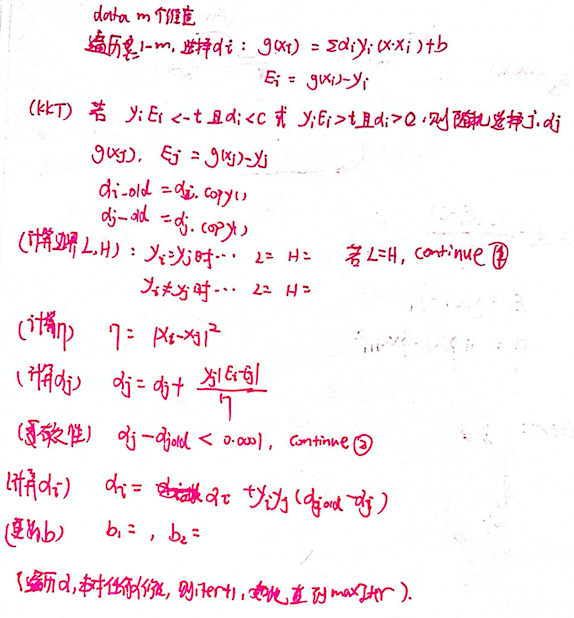

## 3. 根据alpha计算w

In [4]:
def weight(data,label,alphas):
    dataMatrix=np.mat(data);labelMatrix=np.mat(label).transpose() #这里labelMatrix形状为m*1
    m,n=dataMatrix.shape
    w=np.mat(np.zeros((1,n))) #初始化w，为1行n列的全零矩阵，n为data维度数
    
    """w=求和(ai*yi*xi),求和对象是支持向量，即，ai>0的样本点，xi，yi为支持向量对应的label和data"""
    for i in range(m):
        if alphas[i]>0:
            w+=labelMatrix[i]*alphas[i]*dataMatrix[i,:]
    return w.tolist()

## 4. 绘图函数
- 绘制样本点
- 绘制分离超平面

In [5]:
"""
绘制样本数据以及决策边界
思路：
1. 将样本数据根据样本类别标签labelMat分别放入不同的坐标集中
2. 根据坐标集合，分别绘制两个类别样本的散点图
3. 决策边界即x2=f(x1),由w1*x1+w2*x2+b=0得到x2(即y=(-b-w1x1)/w2)
"""
def plotBestFit(weights,b,filename):
    dataMat,labelMat=loadDataSet(filename) #加载样本特征、样本类别
    dataArr=np.array(dataMat)
    n=dataArr.shape[0] #n个样本
    xcord1=[];ycord1=[]
    xcord2=[];ycord2=[] #两个类别的样本的xy坐标值，x对应x1,y对应x2
    
    #将样本数据根据样本类别标签labelMat分别放入不同的坐标集中
    for i in range(n):
        if int(labelMat[i])==1: #第i个样本是1类
            xcord1.append(dataArr[i,0]) #第i个样本的x1值
            ycord1.append(dataArr[i,1]) #第i个样本的x2值
        else:
            xcord2.append(dataArr[i,0]) #第i个样本的x1值
            ycord2.append(dataArr[i,1]) #第i个样本的x2值
    
    #绘制两类样本的散点图
    fig=plt.figure(figsize=(12,8))
    plt.scatter(xcord1,ycord1,c="red",s=50,label="label=1")
    plt.scatter(xcord2,ycord2,c="blue",s=50,label="label=-1") #继续在原图上作图
    
    #绘制决策边界
    x=np.arange(-3.0,5.0,0.1)
    y=(-b-weights[0][0]*x)/weights[0][1] #由w1*x1+w2*x2+b=0得到x2(即y)=(-b-w1x1)/w2
    x.shape=(len(x),1);y.shape=(len(x),1) 
    plt.plot(x,y,color="darkorange",linewidth=3.0,label="Boarder") #继续在ax图上作图
    
    plt.xlabel("X1",fontsize=16)
    plt.ylabel("X2",fontsize=16)
    plt.title("SMO BestFit",fontsize=20,fontweight="bold")
    plt.legend() #添加图标注解
    plt.show()

## 5. 检验简化版的SMO函数

### 5.1 第一个数据集(线性可分)

In [6]:
dataMat1,labelMat1=loadDataSet("SMO_data2.txt") #SMO_data2.txt是线性可分数据集
start=time.time()
b1,alphas1=SMOsimple(dataMat1,labelMat1,0.6,0.001,100)
print ("\n","time used:.{0}s".format(time.time()-start))

iter:0; i:0; alpha pair changed:1
L==H
iter:0; i:7; alpha pair changed:2
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
iter:0; i:58; alpha pair changed:3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
iteration numer:0
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
j not moving enough

j not moving enough
j not moving enough
iteration numer:0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:2
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:4
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration numer:5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:6
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration numer:7
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration numer:

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
iteration numer:15
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
iteration numer:16
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:17
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:18
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving e

j not moving enough
j not moving enough
iteration numer:30
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:31
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:32
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:33
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:34
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:35
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:36
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:37
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteratio

j not moving enough
iteration numer:23
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:24
j not moving enough
j not moving enough
j not moving enough
iteration numer:25
j not moving enough
j not moving enough
j not moving enough
iteration numer:26
j not moving enough
j not moving enough
j not moving enough
iteration numer:27
j not moving enough
j not moving enough
j not moving enough
iteration numer:28
j not moving enough
j not moving enough
j not moving enough
iteration numer:29
j not moving enough
j not moving enough
j not moving enough
iteration numer:30
j not moving enough
j not moving enough
j not moving enough
iteration numer:31
j not moving enough
j not moving enough
j not moving enough
iteration numer:32
j not moving enough
j not moving enough
j not moving enough
iteration numer:33
j not moving enough
j not moving enough
j not moving enough
iteration numer:34
j not moving enough
j not moving enough
j not moving enough
iteration nu

In [7]:
b1,alphas1[alphas1>0] #alpha>0对应的样本是支持向量，这些点的alpha值决定了分离超平面的w和b

(matrix([[2.95773585]]),
 matrix([[0.6       , 0.56650837, 0.18528929, 0.6       , 0.6       ]]))

In [8]:
w1=weight(dataMat1,labelMat1,alphas1)
w1

[[0.942318058726908, -1.2564240783025822]]

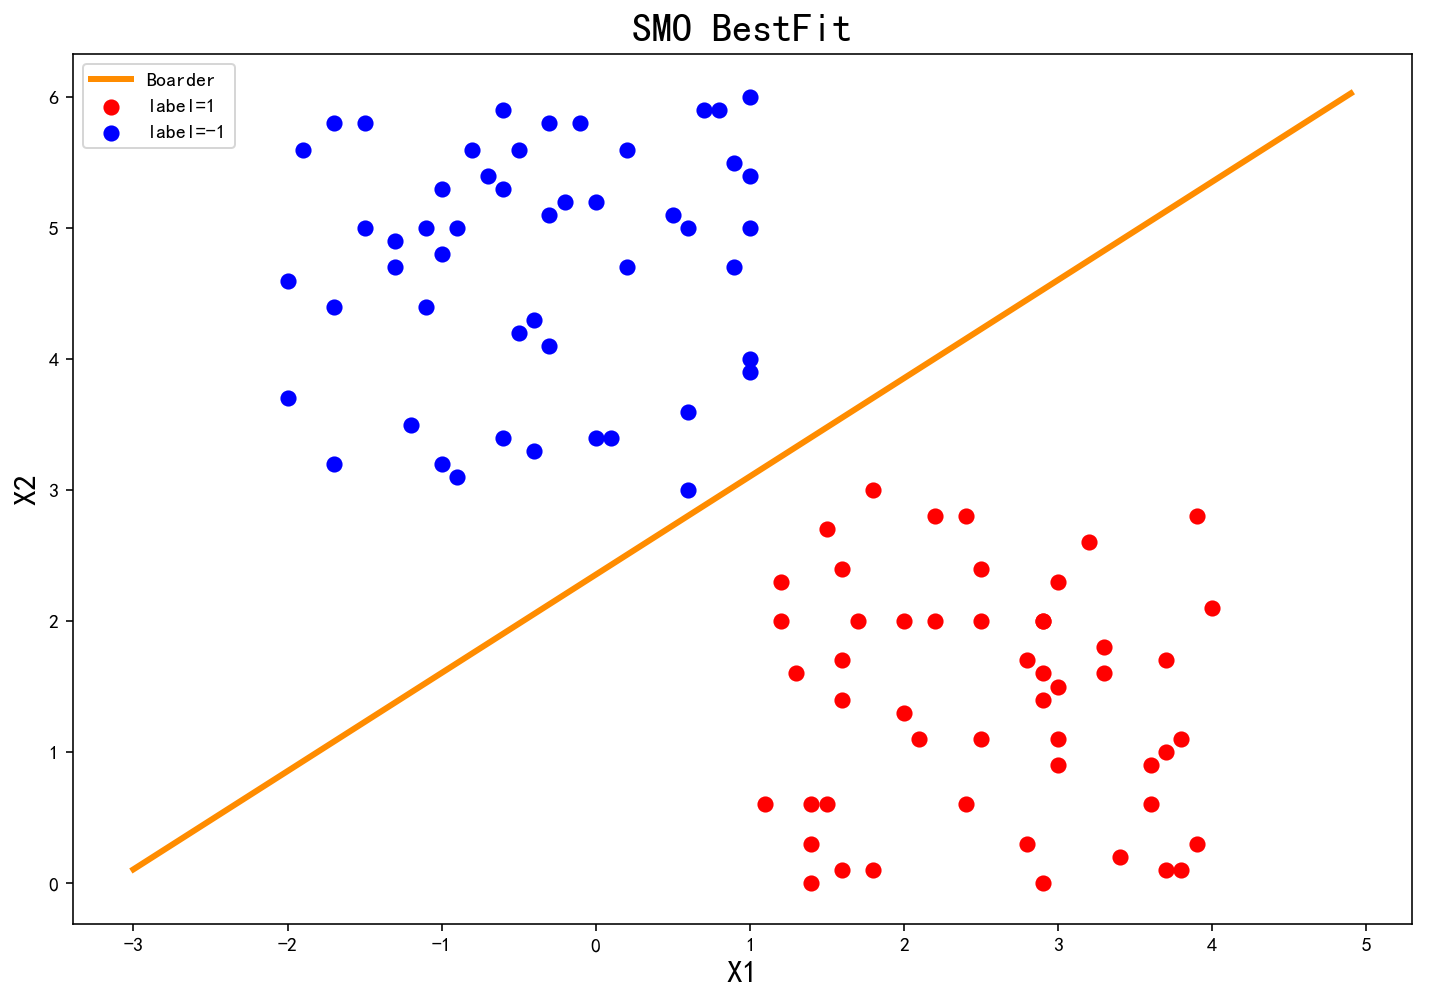

In [9]:
plotBestFit(w1,b1,"SMO_data2.txt")

#### 使用SMO算法得到的分类模型(分离超平面)
- wx+b=0是分离超平面
- 于是将测试样本的x带入wx+b进行计算，结果>0是一类<0是另一类
- 可以看到，在计算结果中，得到>0 <0的两个结果，代表这两个样本点分布在分离超平面两侧，是两类

In [10]:
data_test=np.mat([[0.5,1.5],[-2,4]])
w1_t=w1[0]
gx1=w1_t*data_test.T+b1
gx1

matrix([[ 1.54425876, -3.95259658]])

### 5.2 第二个数据集(线性不可分)

In [11]:
dataMat2,labelMat2=loadDataSet("SMO_data1.txt") #SMO_data1.txt是线性不可分数据集
b2,alphas2=SMOsimple(dataMat2,labelMat2,0.8,0.0001,60) #因为是线性不可分数据集，因此结果对于C敏感，调整C优化结果

L==H
L==H
iter:0; i:2; alpha pair changed:1
j not moving enough
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
iteration numer:0
L==H
j not moving enough
L==H
L==H
L==H
iter:0; i:16; alpha pair changed:1
j not moving enough
j not moving enough
iter:0; i:57; alpha pair changed:2
j not moving enough
j not moving enough
iteration numer:0
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:1
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
L=

j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
iteration numer:17
L==H
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
iteration numer:18
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:6
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:9
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving

j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:6
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:9
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:10
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:11
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:12
j not moving enough
j not moving enough
j not moving enough
j not moving en

j not moving enough
j not moving enough
j not moving enough
L==H
L==H
iteration numer:44
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration numer:45
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
iteration numer:46
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
iteration numer:47
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration numer:48
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
iteration numer:49
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not 

In [12]:
b2,alphas2[alphas2>0] #alpha>0对应的样本是支持向量，这些点的alpha值决定了分离超平面的w和b

(matrix([[84.90168364]]),
 matrix([[8.00000000e-01, 8.00000000e-01, 8.00000000e-01, 5.55111512e-16,
          5.55111512e-16, 8.00000000e-01, 8.00000000e-01]]))

In [13]:
w2=weight(dataMat2,labelMat2,alphas2)
w2

[[2.5008776, -15.224290400000012]]

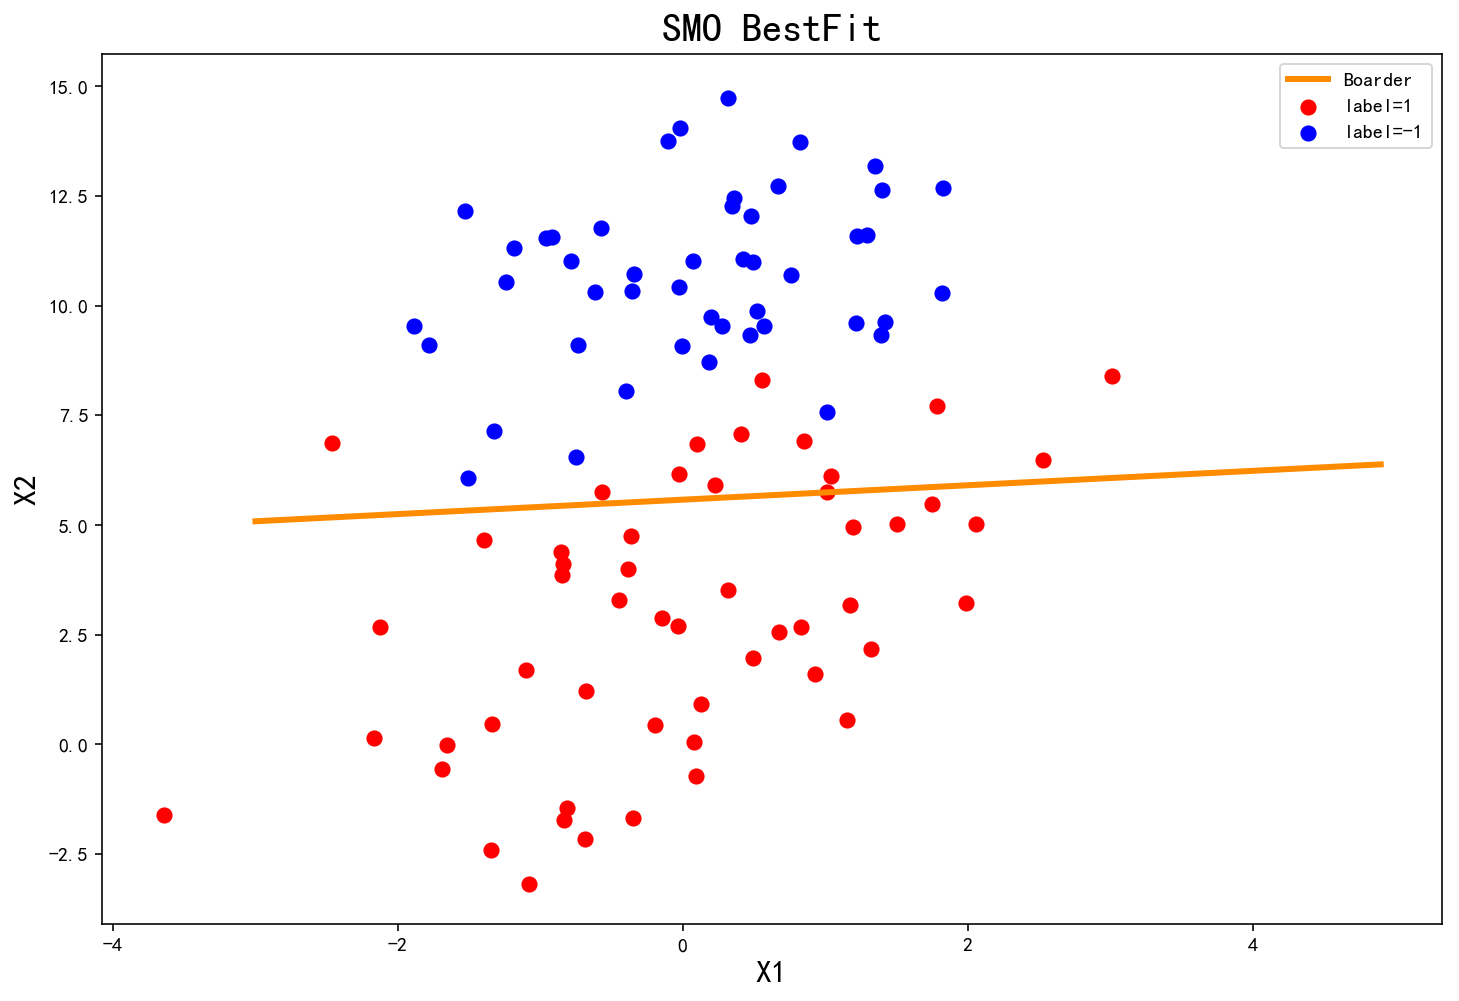

In [14]:
plotBestFit(w2,b2,"SMO_data1.txt")

***
***
## 完整版SMO实现
- 在小规模数据集上，简化版SMO算法没有问题，但对于更大规模的数据集，因为是遍历迭代，运行速度会很慢，怎么办呢？
- 解法：通过启发方法选择ai aj可以显著提速
- **相比于简化版，修改了：**
    - 外循环中用启发方法选择ai：在全集遍历循环和边界遍历循环中切换搜索违反KKT条件超过容错率toler的点
        1. 先遍历全集，若全集遍历中未修改任何alpha，说明alpha均满足KKT条件，循环停止；
        2. 若全集遍历中修改了alpha值，则在下一轮循环进入边界遍历(边界指0<alpha<C的点，是支持向量)；
        3. 在边界遍历中，修改边界点的alpha，直到无alpha可修改(此时alphaPairChanged=0)，再次进入全集遍历；
        4. 如此循环往复，直到全集遍历中未修改任何alpha，循环停止
        - **为什么叫启发式呢？，启发在何处？**
    - 内循环中通过选择相较ai具有最大步长(即Ei-Ej)的aj
    - 每次修改ai aj后，紧跟着修改Ei Ej

## 1. 辅助函数(类)
- 计算Ei的函数
- 选择相较ai具有最大步长(即Ei-Ej)的aj的函数
- 更新Ei矩阵的函数
- 其他辅助函数如读取数据函数、随机选择j函数、剪切alpha函数在简化版中已写好，可以直接使用

In [15]:
def loadDataSet(filename):
    #filename是待读取文件的文件名或路径+文件名
    dataMat=[];labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        lineArr=line.strip().split("\t")
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def randPickj(i,m):
    #i是alphai的i值，整数; m是alpha个数; j不能等于i
    j=i
    while j==i:
        j=int(np.random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    if aj<L:
        aj=L
    return aj

In [82]:
#这里构造一个对象，目的是将此对象作为一个数据结构来使用
class optStruct:
    def __init__(self,data,label,C,toler):
        #全局变量
        self.X=data
        self.labelMatrix=label
        self.C=C
        self.toler=toler
        self.m=data.shape[0] #m为样本数
        
        #初始化alpha矩阵、b、Es矩阵
        self.alphas=np.mat(np.zeros((self.m,1)))
        self.Es=np.mat(np.zeros((self.m,2))) #缓存误差，两列，第一列表示当前Ei是否有效，第二列表示当前的Ei值
        self.b=0
    
def calcEk(oS,k):
    gxk=float(np.multiply(oS.alphas,oS.labelMatrix).transpose()*(oS.X*oS.X[k,:].transpose()))+oS.b
    Ek=gxk-float(oS.labelMatrix[k])
    return Ek
    
#选择相较ai具有最大步长(即Ei-Ej)的aj的函数
def selectJ(oS,i,Ei):
    maxK=-1;maxDeltaE=0;Ej=0 #DeltaE表示Ei-Ej,k表示DeltaE最大的样本点索引值，最终会将Ek赋值给Ej
    oS.Es[i]=[1,Ei] #使Es矩阵第i位有效
    validEsList=np.nonzero(oS.Es[:,0].A)[0] #将Es矩阵中有效的Ei对应的索引值选出来，作为挑选j的池子
        
    if len(validEsList)>1:
        for k in validEsList:
            if k==i:
                continue
            Ek=calcEk(oS,k)
            deltaE=abs(Ei-Ek)
            if deltaE>maxDeltaE:
                maxDeltaE=deltaE;maxK=k;Ej=Ek
        return maxK,Ej
    else: #若validEsList只有一个Ei有效(初次循环)，则随机选取一个j
        j=randPickj(i,oS.m)
        Ej=calcEk(oS,j)
    return j,Ej
    
def updateEk(oS,k):
    Ek=calcEk(oS,k)
    oS.Es[k]=[1,Ek]

## 2. 内循环(aj)
- 外循环是对ai的循环，内循环是在ai选定的基础下对aj的循环
- 代码和逻辑与SMO简化版相似(因为简化版SMO未对外循环做任何优化)

In [16]:
def innerL(i,oS):
    Ei=calcEk(oS,i)
    
    #判断Ei是否是违反KKT条件超过toler的点，若是再继续挑选j
    if (oS.labelMatrix[i]*Ei<-oS.toler and oS.alphas[i]<oS.C) or (oS.labelMatrix[i]*Ei>oS.toler and oS.alphas[i]>0):
        j,Ej=selectJ(oS,i,Ei)
        alphaIold=oS.alphas[i].copy();alphaJold=oS.alphas[j].copy()
        
        #计算L，H
        if oS.labelMatrix[i]!=oS.labelMatrix[j]:
            L=max(0,oS.alphas[j]-oS.alphas[i]) #这里alpha[i]仍然等于alphaIold
            H=min(oS.C,oS.C+oS.alphas[j]-oS.alphas[i])         
        else:
            L=max(0,oS.alphas[j]+oS.alphas[i]-oS.C)
            H=min(oS.C,oS.alphas[j]+oS.alphas[i])
        if L==H:
            print ("L==H")
            return 0 #第一个跳出条件(跳出本次内循环，遍历下一个alpha进行更新)
        
        #计算eta
        eta=oS.X[i,:]*oS.X[i,:].transpose()+oS.X[j,:]*oS.X[j,:].transpose()-2.0*oS.X[i,:]*oS.X[j,:].transpose()
        if eta==0:
            print ("eta=0")
            return 0 #第二个跳出条件(因为eta=0不好处理，且出现情况较少，因此这里咱不处理，直接跳出)
                    
        #根据统计学习方法中的结果公式得到alphaj的解析解，并更新Ej值
        oS.alphas[j]=oS.alphas[j]+oS.labelMatrix[j]*(Ei-Ej)/eta
        oS.alphas[j]=clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j) #更新Ej值
        
        #检验alphaj与alphaJold是否有足够大的改变，若改变不够大，说明与alpha旧值没有什么差异，跳出本次内循环
        if abs(oS.alphas[j]-alphaJold)<0.00001:
            print ("j not moving enough")
            return 0 #第三个跳出条件
                    
        #约束条件让我们可以根据alphaJ求出alphaI
        oS.alphas[i]=oS.alphas[i]+oS.labelMatrix[i]*oS.labelMatrix[j]*(alphaJold-oS.alphas[j])
        updateEk(oS,i) #更新Ei值
        
        #更新b值,根据alpha是否在0～C决定更新的b值
        b1=-Ei-oS.labelMatrix[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].transpose()\
        -oS.labelMatrix[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[i,:].transpose()+oS.b
                
        b2=-Ej-oS.labelMatrix[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].transpose()\
        -oS.labelMatrix[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].transpose()+oS.b
                
        #若ai或aj在(0,C)之间，则取b=bi或b=bj，若ai aj都不在(0,C)之间，取均值
        if oS.alphas[i]>0 and oS.alphas[i]<oS.C:
            oS.b=b1
        elif oS.alphas[j]>0 and oS.alphas[j]<oS.C:
            oS.b=b2
        else:
            oS.b=(b1+b2)/2.0
        return 1 #若执行到这里都没有return0跳出，说明已经完成了一个alpha对的更新，返回一个1
    
    else:
        return 0 #若ai不足够违反KKT条件，则return0跳出本次内循环

## 3. 外循环
- 外循环是对ai的循环，内循环是在ai选定的基础下对aj的循环
- 简化版未对外循环做任何操作，这是完整版SMO与简化版的差异之一
- 外循环选择ai的i的逻辑：遍历全集，若全集无修改alpha对，则说明alpha已符合要求，循环停止；否则下一轮进入边界遍历修改alpha对，直到边界遍历中再无alpha对可修改；则下一轮进入全集遍历，如此循环往复寻找ai，直到全集无修改alpha对时停止

In [17]:
def SMOpro(data,label,C,toler,maxIter,kTup=("lin",0)):
    oS=optStruct(np.mat(data),np.mat(label).transpose(),C,toler)
    iter=0;entireSet=True;alphaPairsChanged=0
    
    #当迭代次数达到上限(这里的迭代次数只要完成一次循环遍历就+1，不论该次循环遍历是否修改了alpha对)，或全集再无可修改的alpha对时，循环停止，计算完成
    while (iter<maxIter) and (entireSet or alphaPairsChanged>0):
        alphaPairsChanged=0
        if entireSet: #全集遍历
            for i in range(oS.m):
                alphaPairsChanged+=innerL(i,oS)
                print ("fullset, iter:%d i:%d, pairsChanged: %d" %(iter,i,alphaPairsChanged))
            iter+=1 #这里的迭代次数只要完成一次循环遍历就+1，不论该次循环遍历是否修改了alpha对
        
        else: #边界遍历
            boundIs=np.nonzero((oS.alphas.A>0)*(oS.alphas.A<oS.C))[0] #选择0<alpha<C的样本点的索引值(即边界点)
            for i in boundIs:
                alphaPairsChanged+=innerL(i,oS)
                print ("bound, iter:%d i:%d, pairsChanged: %d" %(iter,i,alphaPairsChanged))
            iter+=1
            
        #控制遍历往返于全集遍历和边界遍历
        if entireSet:
            entireSet=False #若本轮是全集遍历，则下一轮进入边界遍历(下一轮while条件中的entire是False)
        elif alphaPairsChanged==0:
            entireSet=True  #若本轮是边界遍历，且本轮遍历未修改任何alpha对，则下一轮进入全集遍历
        print ("iteration number: %d" %iter)
    return oS.b,oS.alphas

## 4. 测试

In [18]:
data3,label3=loadDataSet("SMO_data2.txt")
start=time.time()
b3,alphas3=SMOpro(data3,label3,0.6,0.001,60)
print ("\n","time used:.{0}s".format(time.time()-start))

NameError: name 'optStruct' is not defined

#### 完整版SMO v.s. 简化版SMO 时间效率对比
- 简化版用时8.6s
- 完整版用时0.19s
- 效率提升40+倍

In [90]:
print (b3,"\n",alphas3[alphas3>0])

[[ 2.03015087]] 
 [[ 0.45622678  0.49943711  0.35566389  0.6       ]]


In [91]:
w3=weight(data3,label3,alphas3)
w3

[[0.7864740077104758, -0.9541562190807933]]

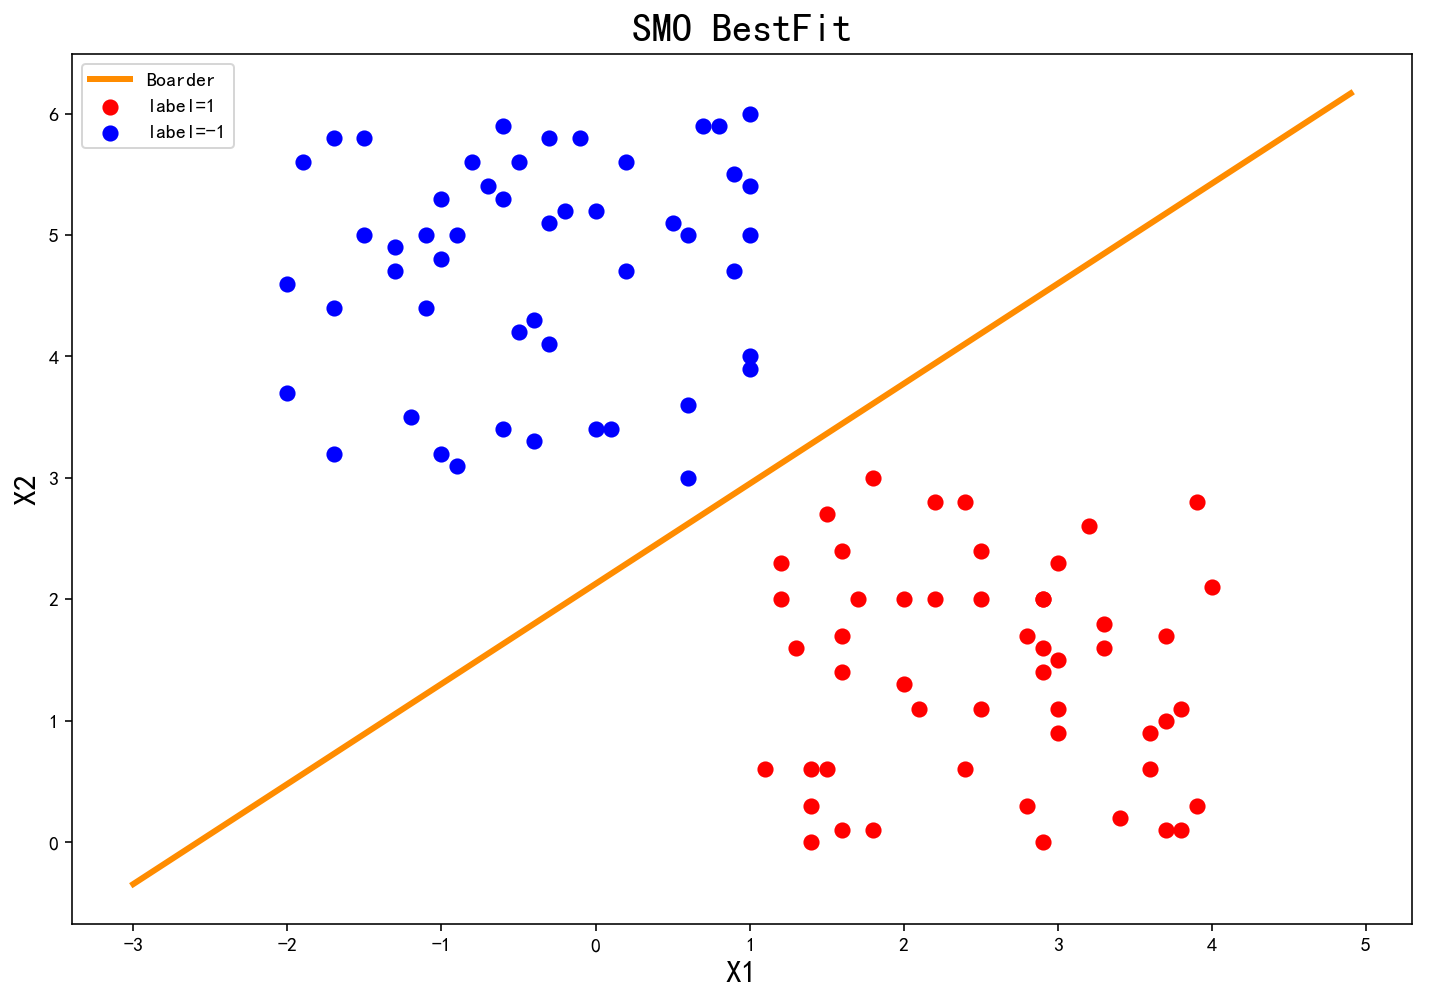

In [92]:
plotBestFit(w3,b3,"SMO_data2.txt")